In [38]:
basepath = 'C:/Users/shaur/Desktop/UTD/ANLP'

In [39]:
import sys
from pathlib import Path

In [40]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/emotion'
model_folder = base_folder/'models/nlp_spring_2024/emotion/nn'
custom_functions = base_folder/'custom_files'
utils_folder = base_folder/'Assign/Emotion Detection/utils'

In [41]:
sys.path.append(str(custom_functions))
sys.path.append(str(utils_folder))
model_folder.mkdir(exist_ok=True, parents = True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter
import re

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from utils import return_id_labels, compute_metrics, test_thresholds, plot_confusion_matrix
from preprocessing import strip_all_entities, clean_hashtags, filter_chars, remove_mult_spaces, demoji_text, convert_emoji

from kaggle import api

### NEW ##########################
# imports from Huggingface ecosystem
import evaluate
from datasets import load_dataset, DatasetDict, Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb

In [108]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [109]:
id2label, label2id = return_id_labels()

## Preprocessing

In [45]:
train_clean = train['Tweet'].apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

pos_weights = torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [46]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [47]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [48]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [49]:
train_label_counts, valid_label_counts = Counter(), Counter()

def update_label_counts(dataset, label_cnts):
    for label_array in dataset['labels']:
        for i, label in enumerate(label_array):
            if label == 1.0:
                label_cnts[i] += 1

update_label_counts(trainset, train_label_counts)
update_label_counts(validset, valid_label_counts)

In [50]:
print("Training set label distribution:")
for label, cnt in train_label_counts.items():
    print(id2label[label], ": ", cnt)

Training set label distribution:
sadness :  2054
anger :  2577
disgust :  2631
joy :  2589
pessimism :  804
anticipation :  994
fear :  1213
optimism :  2060
love :  752
surprise :  368
trust :  346


In [51]:
print("Valid set label distribution:")
for label, cnt in valid_label_counts.items():
    print(id2label[label], ": ", cnt)

Valid set label distribution:
joy :  288
optimism :  231
trust :  54
love :  80
anger :  282
disgust :  290
fear :  150
pessimism :  91
sadness :  219
anticipation :  108
surprise :  28


In [52]:
def calculate_pos_weights(dataset):
    num_labels = len(dataset['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    for label_array in dataset['labels']:
        for i, label in enumerate(label_array):
            if label==1.0: total_positives[i] += 1
            else: total_negatives[i] += 1
            
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

pos_weights = calculate_pos_weights(trainset)
pos_weights

tensor([ 1.6973,  5.9930,  1.6420,  4.7304,  1.6848,  8.2434,  2.3743,  7.6455,
         2.3841, 17.8886, 19.0896])

In [53]:
pos_weights = torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

## Custom Trainer

In [54]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device
        loss_fnct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fnct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [55]:
checkpoint = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [56]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [57]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 773/773 [00:00<00:00, 20011.83 examples/s]


In [58]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
training_args_config = {

    'num_train_epochs': 3,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16, 
    # 'weight_decay': 0.1, # weight decay (L2 regularization)
    # 'learning_rate': 2e-5, # learning arte
    'optim': 'adamw_torch', # optimizer
}

In [61]:
run_name = "twitter_emotion_roberta_large"

training_args = TrainingArguments(
    num_train_epochs=training_args_config.get("num_train_epochs", 3),

    per_device_train_batch_size=training_args_config.get("per_device_train_batch_size", 16),
    per_device_eval_batch_size=training_args_config.get("per_device_eval_batch_size", 16),
    # weight_decay=training_args_config.get("weight_decay", 0.01),  
    # learning_rate=training_args_config.get("learning_rate", 1e-5), 
    lr_scheduler_type='linear',
    warmup_steps=50,
    weight_decay=0.1,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'roberta_twitter_poswts'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=5, 
    metric_for_best_model="loss",
    greater_is_better=False, 

    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases
)

In [62]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [63]:
wandb.login()

run = wandb.init(
    # Set the project where this run will be logged
    project=run_name,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": training_args_config.get("learning_rate", 1e-5),
        "epochs": training_args_config.get("num_train_epochs", 3),
        "train_batch_size": training_args_config.get("per_device_train_batch_size", 16),
        "eval_batch_size": training_args_config.get("per_device_eval_batch_size", 16),
        "weight_decay": training_args_config.get("weight_decay", 0.01)
    },
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▅██
train/global_step,▁▅██
train/grad_norm,█▁
train/learning_rate,█▁
train/loss,█▁


In [64]:
trainer.train()

  8%|▊         | 100/1305 [00:56<13:12,  1.52it/s]

{'loss': 0.7548, 'grad_norm': 5.277898788452148, 'learning_rate': 4.8007968127490044e-05, 'epoch': 0.23}


                                                  
  8%|▊         | 100/1305 [01:00<13:12,  1.52it/s]

{'eval_accuracy': 0.08279430789133248, 'eval_f1': 0.34257771753291966, 'eval_loss': 0.6541640162467957, 'eval_runtime': 4.1028, 'eval_samples_per_second': 188.408, 'eval_steps_per_second': 11.943, 'epoch': 0.23}


 15%|█▌        | 200/1305 [01:58<06:34,  2.80it/s]

{'loss': 0.6074, 'grad_norm': 6.441582202911377, 'learning_rate': 4.402390438247012e-05, 'epoch': 0.46}


                                                  
 15%|█▌        | 200/1305 [02:06<06:34,  2.80it/s]

{'eval_accuracy': 0.13454075032341525, 'eval_f1': 0.503675380116318, 'eval_loss': 0.6083794236183167, 'eval_runtime': 8.0882, 'eval_samples_per_second': 95.572, 'eval_steps_per_second': 6.058, 'epoch': 0.46}


 23%|██▎       | 300/1305 [02:55<01:41,  9.86it/s]  

{'loss': 0.5719, 'grad_norm': 4.186942100524902, 'learning_rate': 4.00398406374502e-05, 'epoch': 0.69}


                                                  
 23%|██▎       | 300/1305 [02:56<01:41,  9.86it/s]

{'eval_accuracy': 0.20310478654592498, 'eval_f1': 0.5612918790007404, 'eval_loss': 0.559130847454071, 'eval_runtime': 1.1937, 'eval_samples_per_second': 647.569, 'eval_steps_per_second': 41.049, 'epoch': 0.69}


 31%|███       | 400/1305 [03:09<01:35,  9.45it/s]

{'loss': 0.5542, 'grad_norm': 2.8575143814086914, 'learning_rate': 3.6055776892430283e-05, 'epoch': 0.92}


                                                  
 31%|███       | 400/1305 [03:11<01:35,  9.45it/s]

{'eval_accuracy': 0.1979301423027167, 'eval_f1': 0.5840056096665641, 'eval_loss': 0.5387178659439087, 'eval_runtime': 1.279, 'eval_samples_per_second': 604.397, 'eval_steps_per_second': 38.312, 'epoch': 0.92}


 38%|███▊      | 500/1305 [03:23<01:23,  9.63it/s]

{'loss': 0.5132, 'grad_norm': 4.033278465270996, 'learning_rate': 3.207171314741036e-05, 'epoch': 1.15}


                                                  
 38%|███▊      | 500/1305 [03:25<01:23,  9.63it/s]

{'eval_accuracy': 0.19146183699870634, 'eval_f1': 0.576758184111194, 'eval_loss': 0.5369397401809692, 'eval_runtime': 1.2729, 'eval_samples_per_second': 607.277, 'eval_steps_per_second': 38.495, 'epoch': 1.15}


 46%|████▌     | 600/1305 [03:38<01:12,  9.71it/s]

{'loss': 0.4743, 'grad_norm': 2.854538679122925, 'learning_rate': 2.8087649402390438e-05, 'epoch': 1.38}


                                                  
 46%|████▌     | 600/1305 [03:39<01:12,  9.71it/s]

{'eval_accuracy': 0.19016817593790428, 'eval_f1': 0.5847376882958423, 'eval_loss': 0.5309349298477173, 'eval_runtime': 1.2586, 'eval_samples_per_second': 614.198, 'eval_steps_per_second': 38.934, 'epoch': 1.38}


 54%|█████▎    | 700/1305 [03:53<01:05,  9.20it/s]

{'loss': 0.4709, 'grad_norm': 5.5015974044799805, 'learning_rate': 2.410358565737052e-05, 'epoch': 1.61}


                                                  
 54%|█████▎    | 700/1305 [03:54<01:05,  9.20it/s]

{'eval_accuracy': 0.2095730918499353, 'eval_f1': 0.6083553086997692, 'eval_loss': 0.5212752223014832, 'eval_runtime': 1.2639, 'eval_samples_per_second': 611.613, 'eval_steps_per_second': 38.77, 'epoch': 1.61}


 61%|██████▏   | 800/1305 [04:08<00:53,  9.40it/s]

{'loss': 0.4684, 'grad_norm': 3.055297374725342, 'learning_rate': 2.01195219123506e-05, 'epoch': 1.84}


                                                  
 61%|██████▏   | 800/1305 [04:09<00:53,  9.40it/s]

{'eval_accuracy': 0.24191461836998707, 'eval_f1': 0.6136631226333769, 'eval_loss': 0.5103836059570312, 'eval_runtime': 1.2665, 'eval_samples_per_second': 610.345, 'eval_steps_per_second': 38.689, 'epoch': 1.84}


 69%|██████▉   | 900/1305 [04:23<00:41,  9.68it/s]

{'loss': 0.4482, 'grad_norm': 3.2774510383605957, 'learning_rate': 1.6135458167330678e-05, 'epoch': 2.07}


                                                  
 69%|██████▉   | 900/1305 [04:24<00:41,  9.68it/s]

{'eval_accuracy': 0.24191461836998707, 'eval_f1': 0.620344947371377, 'eval_loss': 0.5043594837188721, 'eval_runtime': 1.289, 'eval_samples_per_second': 599.674, 'eval_steps_per_second': 38.013, 'epoch': 2.07}


 77%|███████▋  | 1000/1305 [04:38<00:31,  9.72it/s]

{'loss': 0.3993, 'grad_norm': 2.4173665046691895, 'learning_rate': 1.2151394422310758e-05, 'epoch': 2.3}


                                                   
 77%|███████▋  | 1000/1305 [04:39<00:31,  9.72it/s]

{'eval_accuracy': 0.23932729624838292, 'eval_f1': 0.6145082742027044, 'eval_loss': 0.512149453163147, 'eval_runtime': 1.2609, 'eval_samples_per_second': 613.059, 'eval_steps_per_second': 38.861, 'epoch': 2.3}


 84%|████████▍ | 1100/1305 [04:51<00:21,  9.66it/s]

{'loss': 0.396, 'grad_norm': 4.357294082641602, 'learning_rate': 8.167330677290837e-06, 'epoch': 2.53}


                                                   
 84%|████████▍ | 1100/1305 [04:52<00:21,  9.66it/s]

{'eval_accuracy': 0.22897800776196636, 'eval_f1': 0.6134071130749651, 'eval_loss': 0.5067447423934937, 'eval_runtime': 1.2458, 'eval_samples_per_second': 620.462, 'eval_steps_per_second': 39.331, 'epoch': 2.53}


 92%|█████████▏| 1200/1305 [05:04<00:11,  9.47it/s]

{'loss': 0.4087, 'grad_norm': 3.5200603008270264, 'learning_rate': 4.183266932270916e-06, 'epoch': 2.76}


                                                   
 92%|█████████▏| 1200/1305 [05:05<00:11,  9.47it/s]

{'eval_accuracy': 0.21345407503234154, 'eval_f1': 0.6150736551882644, 'eval_loss': 0.5013653635978699, 'eval_runtime': 1.2559, 'eval_samples_per_second': 615.519, 'eval_steps_per_second': 39.017, 'epoch': 2.76}


100%|█████████▉| 1300/1305 [05:18<00:00,  9.44it/s]

{'loss': 0.3809, 'grad_norm': 2.6226980686187744, 'learning_rate': 1.99203187250996e-07, 'epoch': 2.99}


                                                   
100%|█████████▉| 1300/1305 [05:19<00:00,  9.44it/s]

{'eval_accuracy': 0.23673997412677877, 'eval_f1': 0.6259134779681804, 'eval_loss': 0.49799349904060364, 'eval_runtime': 1.2777, 'eval_samples_per_second': 604.989, 'eval_steps_per_second': 38.35, 'epoch': 2.99}


100%|██████████| 1305/1305 [05:21<00:00,  4.06it/s]

{'train_runtime': 321.5148, 'train_samples_per_second': 64.859, 'train_steps_per_second': 4.059, 'train_loss': 0.49574927717333095, 'epoch': 3.0}


TrainOutput(global_step=1305, training_loss=0.49574927717333095, metrics={'train_runtime': 321.5148, 'train_samples_per_second': 64.859, 'train_steps_per_second': 4.059, 'train_loss': 0.49574927717333095, 'epoch': 3.0})

In [65]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 435/435 [00:11<00:00, 38.45it/s]


{'eval_accuracy': 0.3327578765645231,
 'eval_f1': 0.7249217641509804,
 'eval_loss': 0.34626591205596924,
 'eval_runtime': 11.3433,
 'eval_samples_per_second': 612.786,
 'eval_steps_per_second': 38.349,
 'epoch': 3.0}

In [66]:
test_results = trainer.evaluate(validset_tokenized)
test_results

100%|██████████| 49/49 [00:01<00:00, 34.26it/s]


{'eval_accuracy': 0.23673997412677877,
 'eval_f1': 0.6259134779681804,
 'eval_loss': 0.49799349904060364,
 'eval_runtime': 1.4539,
 'eval_samples_per_second': 531.679,
 'eval_steps_per_second': 33.703,
 'epoch': 3.0}

In [67]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})

In [68]:
wandb.finish()

eval/accuracy,▁▂▄▄▄▄▅▅▅▅▅▅▅█▅
eval/f1,▁▄▅▅▅▅▆▆▆▆▆▆▆█▆
eval/loss,█▇▆▅▅▅▅▅▅▅▅▅▄▁▄
eval/runtime,▃▆▁▁▁▁▁▁▁▁▁▁▁█▁
eval/samples_per_second,▂▁█▇▇███▇███▇█▇
eval/steps_per_second,▂▁█▇▇███▇███▇▇▇
test_accuracy,▁
test_f1,▁
test_loss,▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇██████


## Evaluation

100%|██████████| 483/483 [00:13<00:00, 36.86it/s]


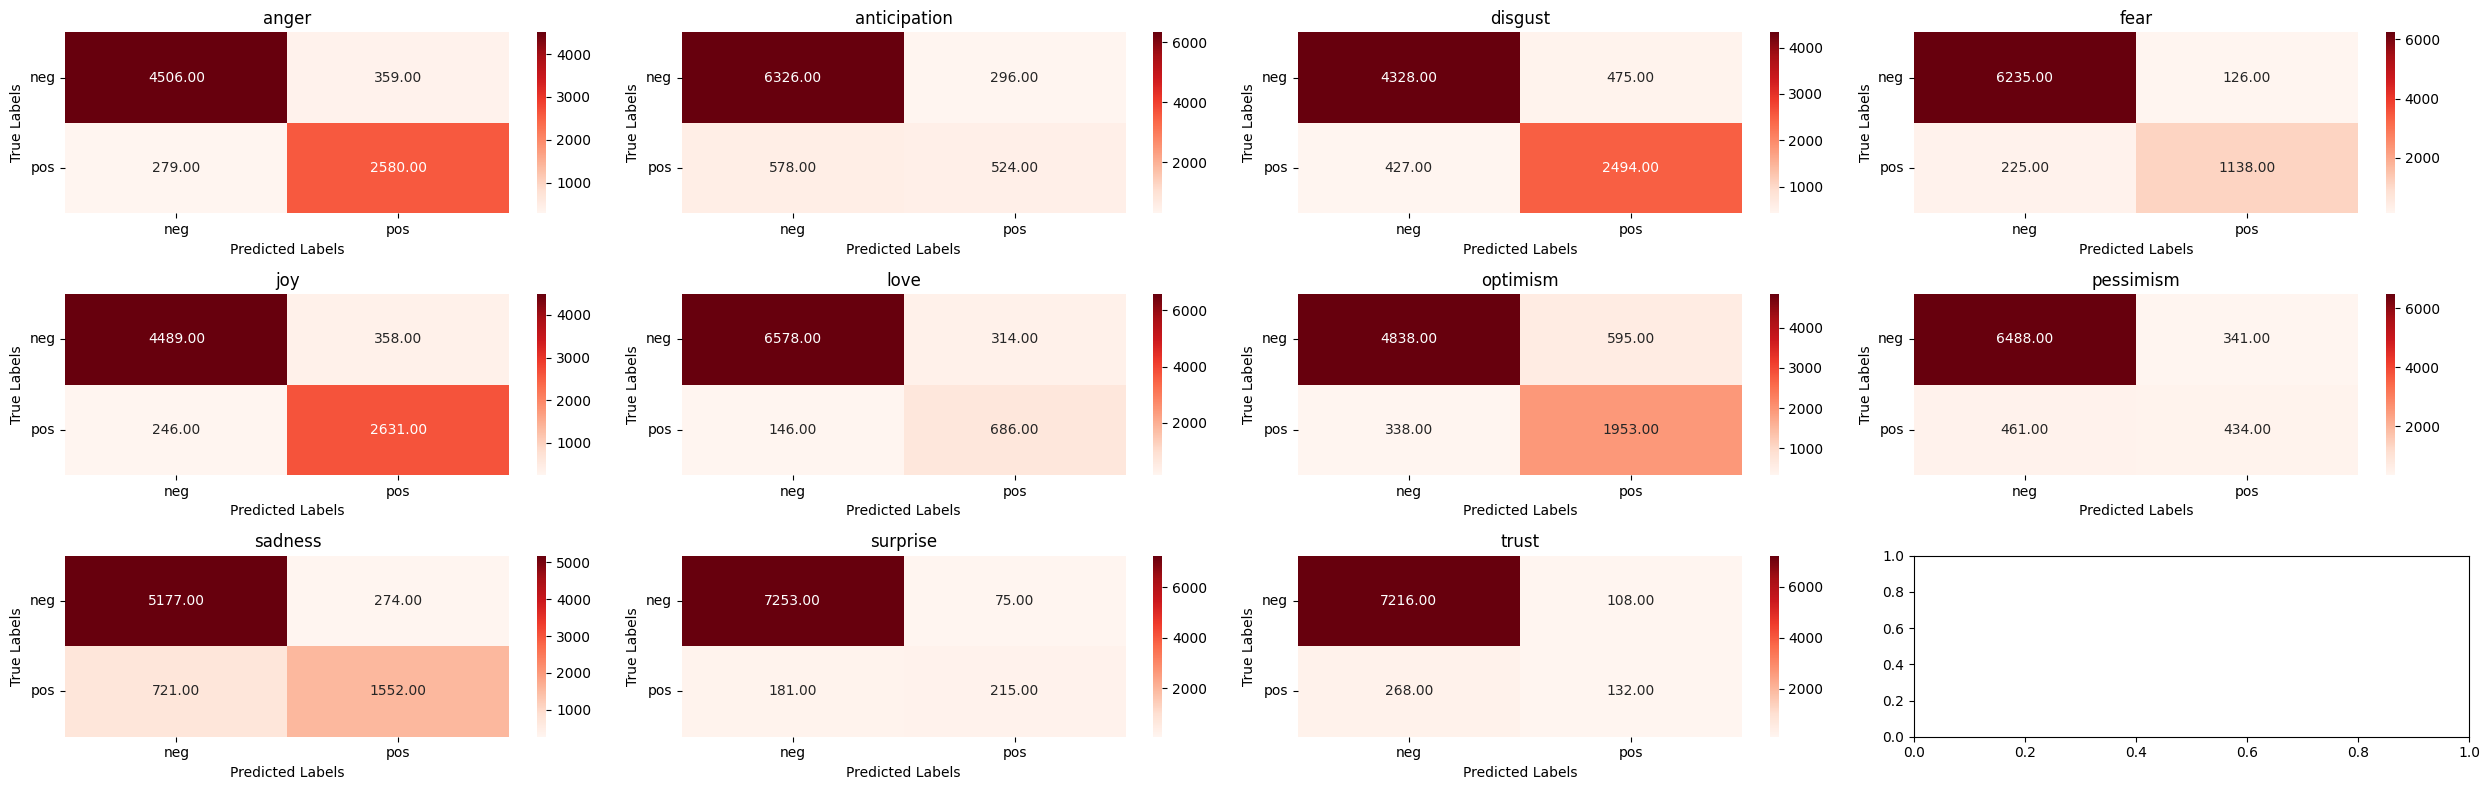

In [104]:
train_output = trainer.predict(trainset_tokenized)

train_preds = np.array(train_output.predictions)
train_preds = np.where(train_preds>0.5, 1., 0.)
train_labels = np.array(train_output.label_ids)

plot_confusion_matrix(train_labels, train_preds, class_labels=['neg', 'pos'])

100%|██████████| 49/49 [00:01<00:00, 40.99it/s]


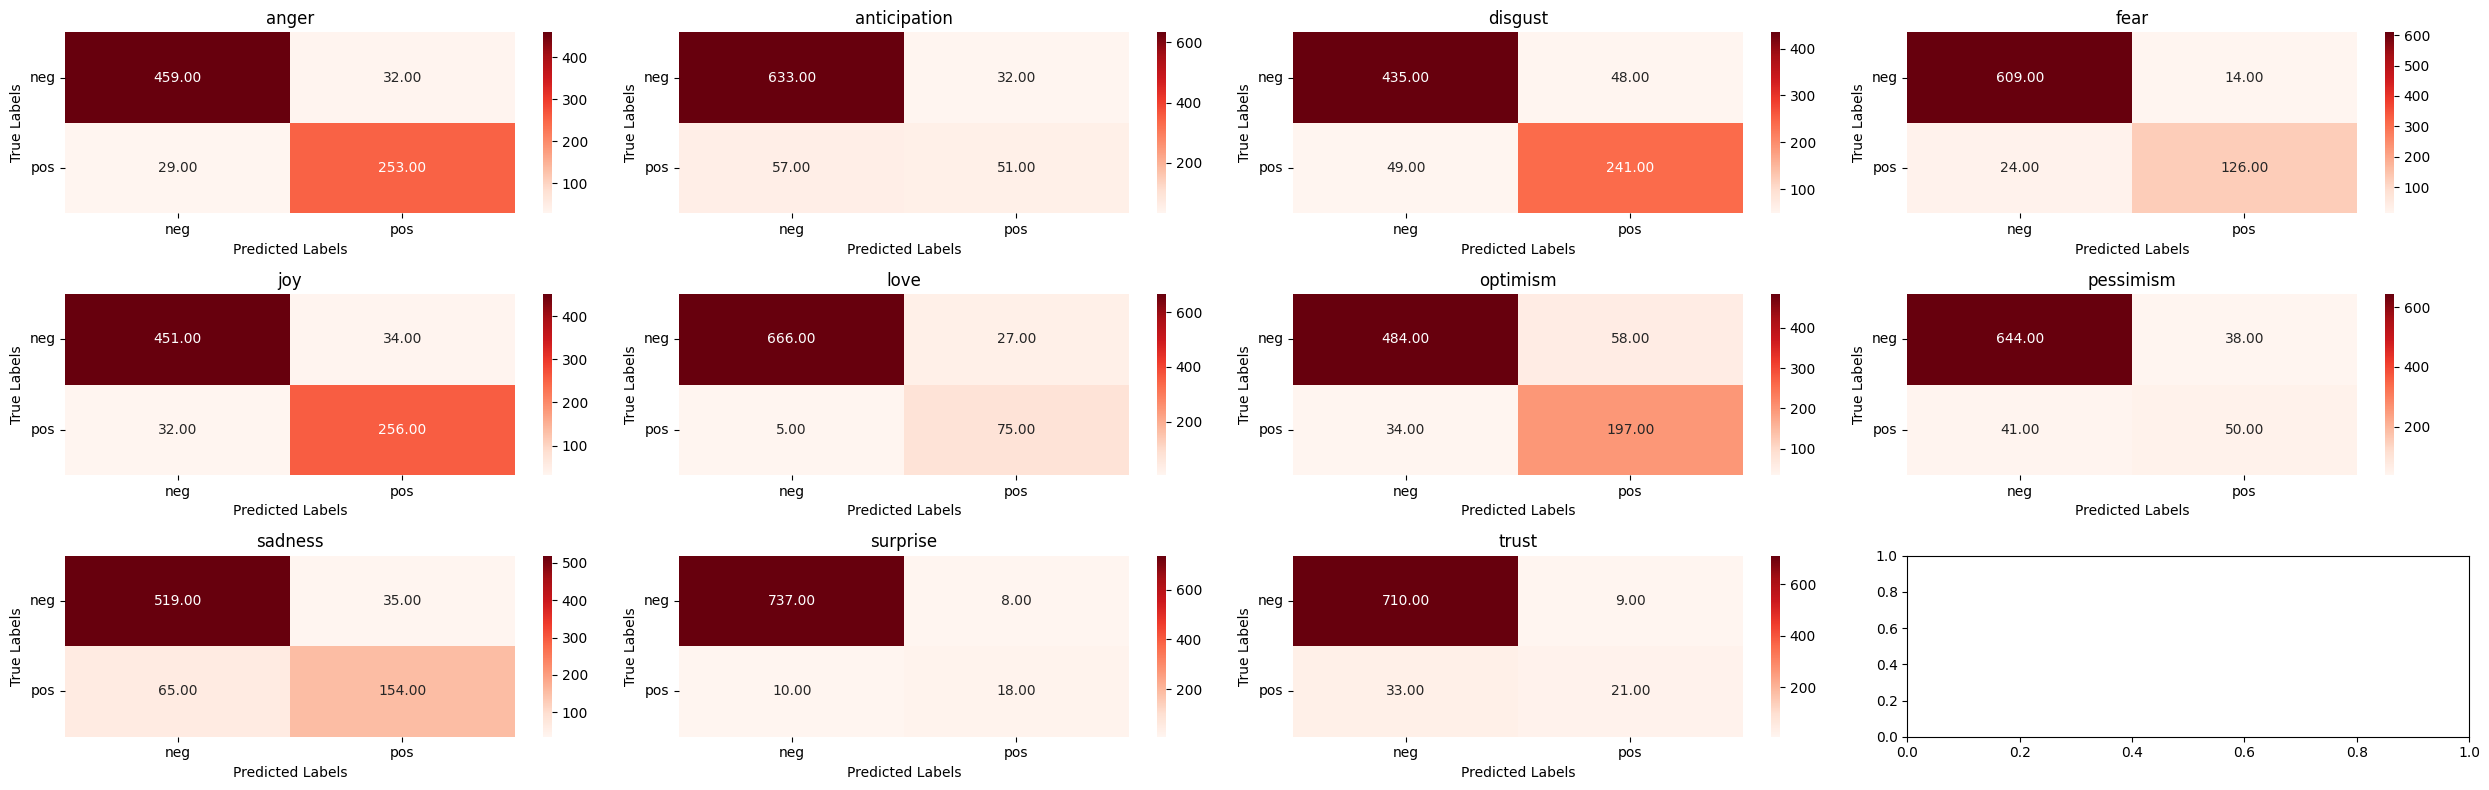

In [102]:
valid_output = trainer.predict(validset_tokenized)

valid_preds = np.array(valid_output.predictions)
valid_preds = np.where(valid_preds>0.5, 1., 0.)
valid_labels = np.array(valid_output.label_ids)

plot_confusion_matrix(valid_labels, valid_preds, class_labels=['neg', 'pos'])

In [69]:
best_model_checkpoint_step = 1300
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 1300.


In [70]:
checkpoint = str(model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

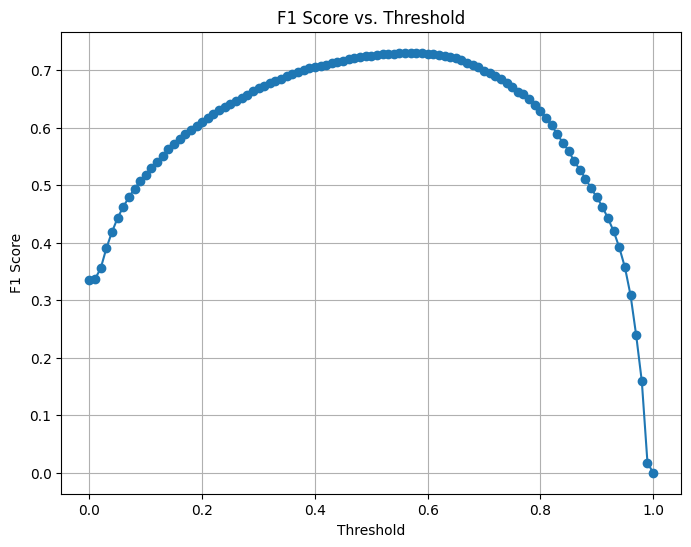

Best Threshold: 0.56
Best F1 Score: 0.7301032781005553


In [71]:
preds = custom_pipeline(trainset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

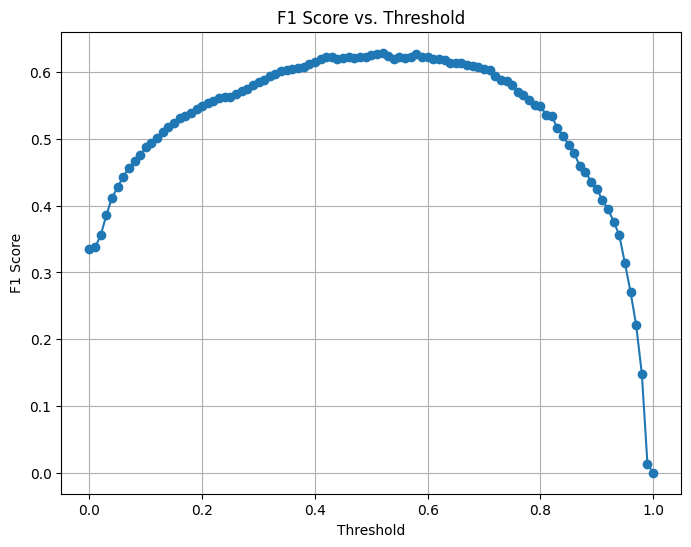

Best Threshold: 0.52
Best F1 Score: 0.6290590833878896


In [72]:
preds = custom_pipeline(validset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(validset['labels'], preds, thresholds)

## Training model on whole dataset

In [81]:
trainset = Dataset.from_dict({
    'texts': X,
    'labels': y
})

In [82]:
checkpoint = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [83]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')




Map: 100%|██████████| 7724/7724 [00:00<00:00, 20078.03 examples/s]


In [84]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
training_args = TrainingArguments(
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    lr_scheduler_type='linear',
    warmup_steps=50,
    weight_decay=0.1,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'roberta_twitter_poswts'), 
    # evaluation_strategy='steps', 
    # eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    # load_best_model_at_end=True, 
    save_total_limit=5, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)


In [86]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    # eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

 35%|███▍      | 500/1449 [01:06<01:46,  8.92it/s]

{'loss': 0.6155, 'grad_norm': 3.427804946899414, 'learning_rate': 3.391708363116512e-05, 'epoch': 1.04}


 69%|██████▉   | 1000/1449 [02:14<00:52,  8.61it/s]

{'loss': 0.471, 'grad_norm': 2.755974769592285, 'learning_rate': 1.6047176554681916e-05, 'epoch': 2.07}


100%|██████████| 1449/1449 [03:15<00:00,  7.40it/s]

{'train_runtime': 195.9234, 'train_samples_per_second': 118.271, 'train_steps_per_second': 7.396, 'train_loss': 0.49794461268075507, 'epoch': 3.0}


TrainOutput(global_step=1449, training_loss=0.49794461268075507, metrics={'train_runtime': 195.9234, 'train_samples_per_second': 118.271, 'train_steps_per_second': 7.396, 'train_loss': 0.49794461268075507, 'epoch': 3.0})

In [87]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 483/483 [00:13<00:00, 35.60it/s]


{'eval_accuracy': 0.3406266183324702,
 'eval_f1': 0.7290192773178839,
 'eval_loss': 0.34633105993270874,
 'eval_runtime': 13.6003,
 'eval_samples_per_second': 567.929,
 'eval_steps_per_second': 35.514,
 'epoch': 3.0}

## Evaluation

In [88]:
best_model_checkpoint_step = 1400
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 1400.


In [89]:
checkpoint = str(model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

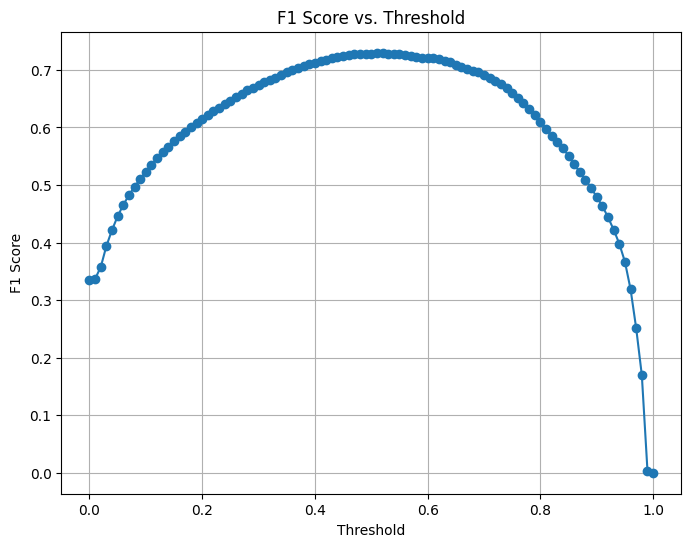

Best Threshold: 0.52
Best F1 Score: 0.7297702610308257


In [90]:
preds = custom_pipeline(trainset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

## Submission to Kaggle

In [91]:
X_test = test['Tweet']
X_test_cleaned = X_test.apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).values

In [92]:
testset = Dataset.from_dict({
    'texts': X_test_cleaned,
})

In [93]:
preds = custom_pipeline(testset['texts'])

In [94]:
pred_df = pd.DataFrame(columns=test.columns[2:])

for pred in preds:
    temp_ans = label2id
    for pred_label in pred:
        if pred_label['score']>0.52:
            temp_ans[pred_label['label']] = 1
        else: 
            temp_ans[pred_label['label']] = 0
    pred_df = pd.concat([pred_df, pd.DataFrame([temp_ans])], ignore_index=True)

In [95]:
sub_df = pd.concat([test[['ID']], pred_df], axis=1)
sub_df.to_csv(model_folder/'pos_wts_sub.csv', index = False)

In [96]:
# comp = 'emotion-detection-spring2014'
# api.competition_submit(model_folder/'pos_wts_sub.csv', 'Positional Wts', comp)

100%|██████████| 108k/108k [00:00<00:00, 161kB/s]  


Successfully submitted to Emotion Detection Spring2024